In [78]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import math

import h5py
import matplotlib.pyplot as plt
import torch

from juart import NonCartesianGrappa, fourier_transform_adjoint, resize
from juart.recon.cgnufft import cgnufft

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Non-Cartesian GRAPPA Reconstruction
This is an example for the non-cartesian GRAPPA algorithm using spiral k-space data from a water phantom measurement.

The non-cartesian GRAPPA algorithm uses a sampling mask in an additional spatial dimension of the non-cartesian k-space trajectory
to identifiy unsampled (k[-1]=0) and sampled (k[-1]=1) data. <br>
The actual trajectory values are scaled in units of [cycles/fov].

The k-space signal data should contain zeros at the unsampled locations.

A small autocalibration region is used to perform the calibration of the non-cartesian GRAPPA kernel.

For further information about the implementation refere to: <br> 
Luo, Tianrui, Douglas C. Noll, Jeffrey A. Fessler, and Jon-Fredrik Nielsen. ‘A GRAPPA Algorithm for Arbitrary 2D/3D Non-Cartesian Sampling Trajectories with Rapid Calibration’. Magnetic Resonance in Medicine 82, no. 3 (2019): 1101–12. https://doi.org/10.1002/mrm.27801.


In [38]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cpu


## Load example dataset

In [4]:
with h5py.File("data/recon.h5", "r") as f:
    print(f"Datset contains the following keys: {f.keys()}")
    print(f"ACS region contains the following keys: {f['acs'].keys()}")

    # Load k-space data and trajectory
    ksp_spiral = torch.tensor(f["image/data"][:], dtype=torch.complex64, device=device)
    ktraj_spiral = torch.tensor(f["image/ktraj"][:], dtype=torch.float32, device=device)

    # Load ACS data and coil sensitivities
    ksp_acs = torch.tensor(f["acs/data_comp"][:], dtype=torch.complex64, device=device)
    coil_sens = torch.tensor(
        f["acs/sens_maps"][:], dtype=torch.complex64, device=device
    )

    # Load metadata
    fov = torch.tensor(f.attrs["fov"], dtype=torch.float32)
    matrix = torch.tensor(f.attrs["matrix"], dtype=torch.int32)

    # Bring to Juart format
    ksp_acs = ksp_acs.moveaxis(3, 0)  # Move coil dimension to the front
    coil_sens = coil_sens.moveaxis(3, 0)  # Move coil dimension to the front

    num_dim, num_col, num_slc, num_eco = ktraj_spiral.shape
    num_cha, *_ = ksp_spiral.shape

    print("Field of view [m]: ", fov)
    print("Matrix size: ", matrix)
    print("k-space signal shape: ", ksp_spiral.shape)
    print("k-space trajectory shape: ", ktraj_spiral.shape)
    print("ACS signal shape: ", ksp_acs.shape)
    print("Coil sensitivity maps shape: ", coil_sens.shape)

    # Scale trajectory in units of cycles per FOV
    ktraj_spiral = ktraj_spiral * fov[:-1]
    print(
        "Scaled k-space trajectory min/max:"
        f"{ktraj_spiral.min().item()} / {ktraj_spiral.max().item()}"
    )

Datset contains the following keys: <KeysViewHDF5 ['acs', 'image']>
ACS region contains the following keys: <KeysViewHDF5 ['data_comp', 'sens_maps']>
Field of view [m]:  tensor([0.2400, 0.2400, 0.1050])
Matrix size:  tensor([96, 96, 30], dtype=torch.int32)
k-space signal shape:  torch.Size([12, 3090, 30, 2])
k-space trajectory shape:  torch.Size([2, 3090, 30, 2])
ACS signal shape:  torch.Size([12, 96, 96, 1, 30])
Coil sensitivity maps shape:  torch.Size([12, 96, 96, 1, 30])
Scaled k-space trajectory min/max:-48.0489501953125 / 47.4658088684082


## Visual inspection of the data

Show k-space trajectory and the signal magnitude

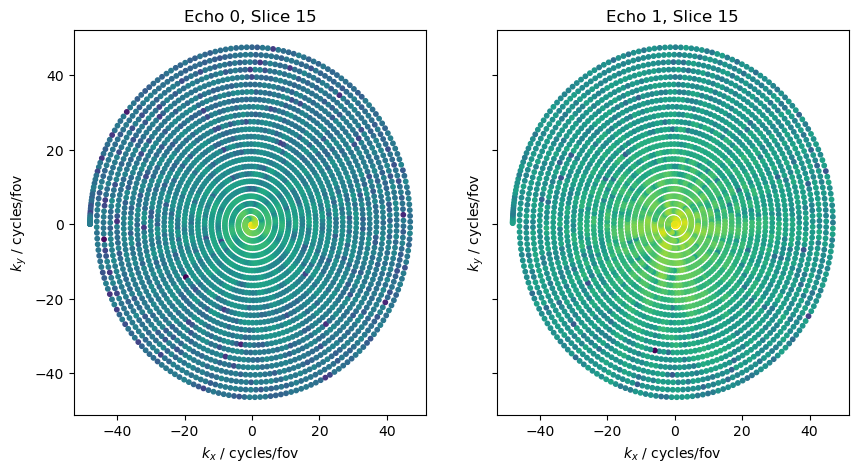

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

n_center_slc = num_slc // 2

for n_eco in range(num_eco):
    axes[n_eco].set_title(f"Echo {n_eco}, Slice {n_center_slc}")
    axes[n_eco].scatter(
        ktraj_spiral[0, :, n_center_slc, n_eco],
        ktraj_spiral[1, :, n_center_slc, n_eco],
        s=10,
        c=torch.abs(ksp_spiral[0, :, n_center_slc, n_eco]),
        norm="log",
    )
    axes[n_eco].set_xlabel(r"$k_x$ / cycles/fov")
    axes[n_eco].set_ylabel(r"$k_y$ / cycles/fov")

plt.show()

Show sensitivity maps calculated from the ACS data.

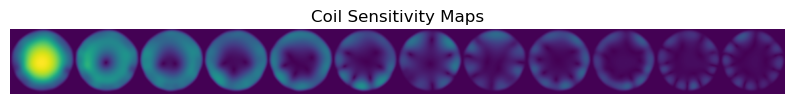

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.set_title("Coil Sensitivity Maps")
ax.imshow(
    torch.abs(coil_sens[..., 0, n_center_slc].reshape(-1, coil_sens.shape[2]).T),
)
ax.set_axis_off()
plt.show()

# Non-Cartesian GRAPPA reconstruction

The data does yet not include the unsampled locations in k-space which have to be interpolated by the GRAPPA reconstruction.

Therefore, we reconstruct the data directly on a cartesian grid.

In [ ]:
# Create a cartesian grid in k-space
xs = torch.arange(-matrix[0] // 2, matrix[0] // 2, device=device, dtype=torch.float32)
ys = torch.arange(-matrix[1] // 2, matrix[1] // 2, device=device, dtype=torch.float32)
x, y = torch.meshgrid(xs, ys, indexing="xy")
grid = torch.stack([x, y], dim=0)

# Ravel grid and repeat for slices and echoes
grid_ravel = grid.reshape(2, -1, 1, 1).repeat(1, 1, num_slc, num_eco)
grid_samples = torch.zeros(
    (num_cha, *grid_ravel.shape[1:]), dtype=torch.complex64, device=device
)

# Add a sampling mask containing zeros for the cartesian sample points to calibrate
grid_ravel = torch.cat(
    [grid_ravel, torch.zeros(1, *grid_ravel.shape[1:], device=device)],
    dim=0,
)

# Add a sampling mask containing ones for the measured spiral sample points.
ktraj_comb_grid = torch.cat(
    [ktraj_spiral, torch.ones(1, *ktraj_spiral.shape[1:], device=device)],
    dim=0,
)

# Combine ktraj
ktraj_comb_grid = torch.cat([ktraj_comb_grid, grid_ravel], dim=1)

# Combine ksp
ksp_comb_grid = torch.cat([ksp_spiral, grid_samples], dim=1)


print("Combined k-space signal shape: ", ksp_comb_grid.shape)
print("Combined k-space trajectory shape: ", ktraj_comb_grid.shape)

Combined k-space signal shape:  torch.Size([12, 12306, 30, 2])
Combined k-space trajectory shape:  torch.Size([3, 12306, 30, 2])


## Prepare ACS k-space data

ACS data must have quadrativ support in k-space

In [ ]:
# Cut ACS to support region
acs_size = 30
ksp_acs = resize(ksp_acs, size=(acs_size, acs_size), dims=(1, 2))

In [15]:
ksp_acs.shape

torch.Size([12, 30, 30, 1, 30])

# Perform GRAPPA reconstruction to a cartesian grid

In [ ]:
img_ncgrappa_grid = torch.zeros(
    (num_cha, *tuple(matrix[:-1].tolist()), num_slc, num_eco),
    dtype=torch.complex64,
    device=device,
)
for n_slc in range(num_slc):
    for n_eco in range(num_eco):
        print(f"Reconstructing slice {n_slc}, echo {n_eco}")
        # Calculate weights for ncgrappa
        ncgrappa = NonCartesianGrappa(
            ktraj=ktraj_comb_grid[:, :, n_slc, n_eco],
            calib_signal=ksp_acs[..., 0, n_slc],
            kernel_size=(7, 7),
            tik=5e-9,
            verbose=0,
        )

        # Apply weights to reconstruct missing k-space points
        ksp_filled = ncgrappa.apply(ksp=ksp_comb_grid[:, :, n_slc, n_eco])

        # Take only cartesian data from filled ksp
        sample_mask = ktraj_comb_grid[-1, :, n_slc, n_eco] == 1
        ksp_filled_cart = ksp_filled[:, ~sample_mask]

        ksp_filled_cart = ksp_filled_cart.reshape(num_cha, *tuple(matrix[:-1].tolist()))

        img_tmp = fourier_transform_adjoint(ksp_filled_cart, axes=(1, 2))

        img_ncgrappa_grid[:, :, :, n_slc, n_eco] = img_tmp

Reconstructing slice 0, echo 0
Reconstructing slice 0, echo 1
Reconstructing slice 1, echo 0
Reconstructing slice 1, echo 1
Reconstructing slice 2, echo 0
Reconstructing slice 2, echo 1
Reconstructing slice 3, echo 0
Reconstructing slice 3, echo 1
Reconstructing slice 4, echo 0
Reconstructing slice 4, echo 1
Reconstructing slice 5, echo 0
Reconstructing slice 5, echo 1
Reconstructing slice 6, echo 0
Reconstructing slice 6, echo 1
Reconstructing slice 7, echo 0
Reconstructing slice 7, echo 1
Reconstructing slice 8, echo 0
Reconstructing slice 8, echo 1
Reconstructing slice 9, echo 0
Reconstructing slice 9, echo 1
Reconstructing slice 10, echo 0
Reconstructing slice 10, echo 1
Reconstructing slice 11, echo 0
Reconstructing slice 11, echo 1
Reconstructing slice 12, echo 0
Reconstructing slice 12, echo 1
Reconstructing slice 13, echo 0
Reconstructing slice 13, echo 1
Reconstructing slice 14, echo 0
Reconstructing slice 14, echo 1
Reconstructing slice 15, echo 0
Reconstructing slice 15, ech

Calculate normalized root-sum-of-squares (RSS) image

In [33]:
img_rss_ncgrappa_grid = torch.sqrt(
    torch.sum(torch.abs(img_ncgrappa_grid) ** 2, dim=0, keepdim=True)
)
img_rss_ncgrappa_grid = img_rss_ncgrappa_grid / img_rss_ncgrappa_grid.max()

Show reconstructed images for the non-cartesian GRAPPA reconstruction on a cartesian grid.

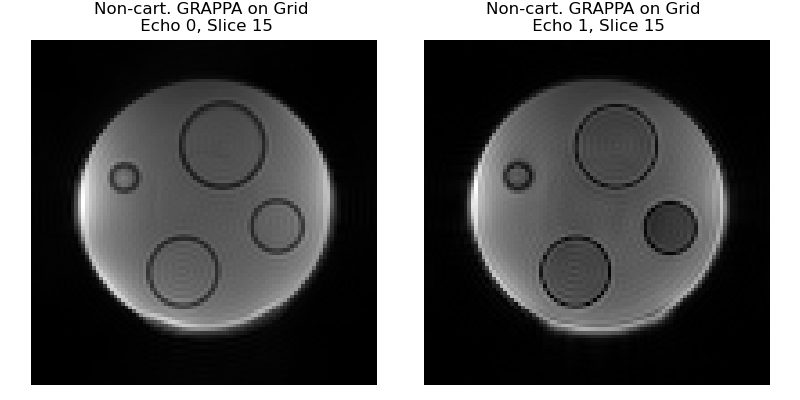

In [50]:
show_slc = 15

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

for n_eco in range(num_eco):
    axes[n_eco].set_title(f"Non-cart. GRAPPA on Grid \n Echo {n_eco}, Slice {show_slc}")
    axes[n_eco].imshow(
        torch.abs(img_rss_ncgrappa_grid[0, :, :, show_slc, n_eco]),
        cmap="gray",
    )
    axes[n_eco].set_axis_off()
plt.tight_layout()
plt.show()

# Perform GRAPPA reconstruction to spiral trajectory

We can also reconstruct the locations of the missing spiral interleaves.
The locations in k-space are rotated copies of the single interleave we have measured.

In [69]:
# Create missing trajectory points by rotating the original trajectory
num_lve = 1
pi_acc = 2
total_lve = num_lve * pi_acc

dphi = 2 * torch.pi / total_lve

rot_mat = torch.tensor(
    [
        [math.cos(dphi), -math.sin(dphi)],
        [math.sin(dphi), math.cos(dphi)],
    ],
    device=device,
)

ktraj_spiral_missing = ktraj_spiral @ rot_mat.T

# Add sampling masks
mask_spiral_missing = torch.zeros(1, *ktraj_spiral_missing.shape[1:], device=device)
ktraj_spiral_missing = torch.cat([ktraj_spiral_missing, mask_spiral_missing], dim=0)

mask_sprial_measured = torch.ones(1, *ktraj_spiral.shape[1:], device=device)
ktraj_spiral_comb = torch.cat([ktraj_spiral, mask_sprial_measured], dim=0)

# Add unsampled and sampled trajectory
ktraj_spiral_comb = torch.cat([ktraj_spiral_comb, ktraj_spiral_missing], dim=1)

# Add k-space data and zeros for missing points
ksp_spiral_missing = torch.zeros(ksp_spiral.shape, dtype=torch.complex64, device=device)
ksp_spiral_comb = torch.cat([ksp_spiral, ksp_spiral_missing], dim=1)

print("Shape of combined trajectory: ", list(ktraj_spiral_comb.shape))
print("Shape of combined k-space data: ", list(ksp_spiral_comb.shape))

Shape of combined trajectory:  [3, 6180, 30, 2]
Shape of combined k-space data:  [12, 6180, 30, 2]


/tmp/ipykernel_654/2608566381.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)


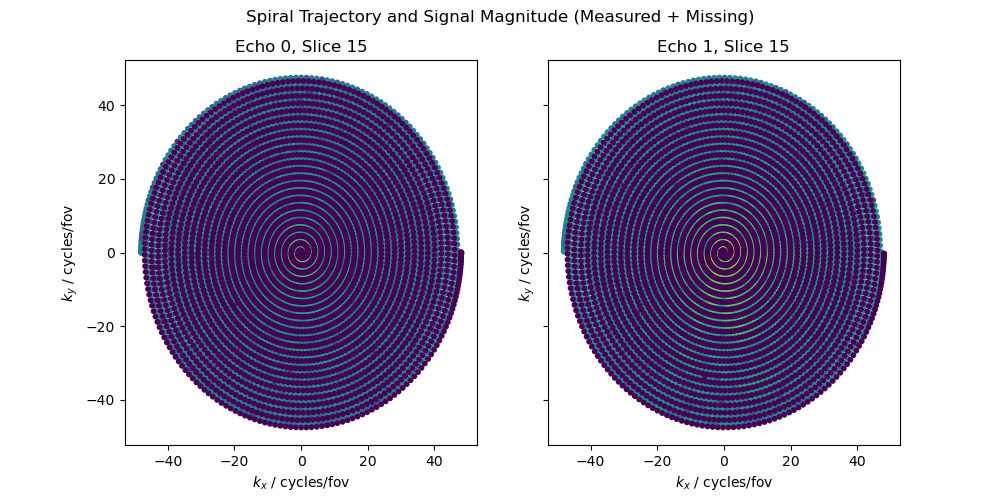

In [76]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

fig.suptitle("Spiral Trajectory and Signal Magnitude (Measured + Missing)")

n_center_slc = num_slc // 2

for n_eco in range(num_eco):
    axes[n_eco].set_title(f"Echo {n_eco}, Slice {n_center_slc}")
    axes[n_eco].scatter(
        ktraj_spiral_comb[0, :, n_center_slc, n_eco],
        ktraj_spiral_comb[1, :, n_center_slc, n_eco],
        s=10,
        c=torch.abs(ksp_spiral_comb[0, :, n_center_slc, n_eco]) + 1e-6,
        norm="log",
    )

    axes[n_eco].set_xlabel(r"$k_x$ / cycles/fov")
    axes[n_eco].set_ylabel(r"$k_y$ / cycles/fov")

plt.show()

In [ ]:
# Perform GRAPPA reconstruction to a spiral interleaves
img_ncgrappa_leaves = torch.zeros(
    (num_cha, *tuple(matrix[:-1].tolist()), num_slc, num_eco),
    dtype=torch.complex64,
    device=device,
)
for n_slc in range(num_slc):
    for n_eco in range(num_eco):
        print(f"Reconstructing slice {n_slc}, echo {n_eco}")
        # Calculate weights for ncgrappa
        ncgrappa = NonCartesianGrappa(
            ktraj=ktraj_spiral_comb[:, :, n_slc, n_eco],
            calib_signal=ksp_acs[..., 0, n_slc],
            kernel_size=(7, 7),
            tik=5e-9,
            verbose=0,
        )

        # Apply weights to reconstruct missing k-space points
        ksp_filled = ncgrappa.apply(ksp=ksp_spiral_comb[:, :, n_slc, n_eco])

        # Different scaling
        ktraj_tmp = ktraj_spiral_comb[:-1, :, n_slc, n_eco] / (matrix[0])
        img_tmp = cgnufft(
            ksp=ksp_filled,
            ktraj=ktraj_tmp,
            img_size=matrix[:-1].tolist(),
            maxiter=15,
            l2_reg=1e-9,
            device=device,
        )

        img_ncgrappa_leaves[:, :, :, n_slc, n_eco] = img_tmp.squeeze()

# Caluculate root-sum-of-squares image
img_rss_ncgrappa_leaves = torch.sqrt(
    torch.sum(torch.abs(img_ncgrappa_leaves) ** 2, dim=0, keepdim=True)
)

Reconstructing slice 10, echo 0
Reconstructing slice 10, echo 1
Reconstructing slice 11, echo 0
Reconstructing slice 11, echo 1


## Show non-cartesian GRAPPA reconstruction on spiral interleave

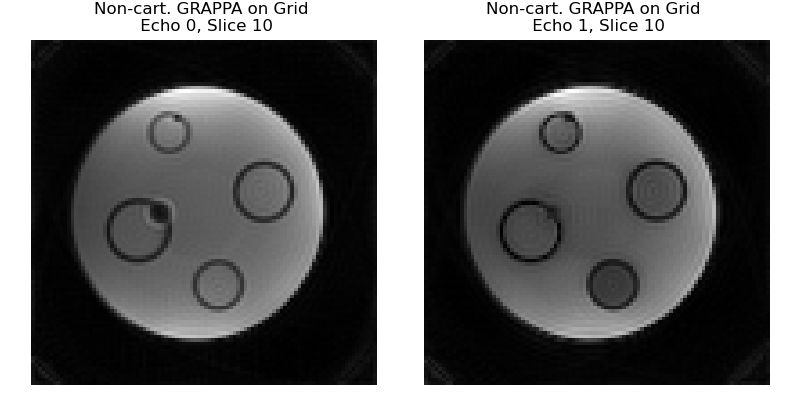

In [83]:
show_slc = 10

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

for n_eco in range(num_eco):
    axes[n_eco].set_title(f"Non-cart. GRAPPA on Grid \n Echo {n_eco}, Slice {show_slc}")
    axes[n_eco].imshow(
        torch.abs(img_rss_ncgrappa_leaves[0, :, :, show_slc, n_eco]),
        cmap="gray",
    )
    axes[n_eco].set_axis_off()
plt.tight_layout()
plt.show()

In [107]:
a = torch.rand((10, 64, 64, 1))
b = torch.rand((5, 10, 64, 64, 1))

(a * b).shape

torch.Size([5, 10, 64, 64, 1])

# SENSE Reconstruction

In [ ]:
from juart.recon.sense import cgsense

coil_sens_flip = coil_sens.clone()

img = cgsense(
    ksp_data=ksp_spiral[:, :, num_slc // 2, :].contiguous(),
    ktraj=ktraj_spiral[:, :, num_slc // 2, :].contiguous() / matrix[0],
    coil_sensitivities=coil_sens_flip[..., num_slc // 2].contiguous(),
    maxiter=20,
    verbose=True,
)

RuntimeError: The size of tensor a (12) must match the size of tensor b (96) at non-singleton dimension 1

(np.float64(-0.5), np.float64(95.5), np.float64(-0.5), np.float64(95.5))

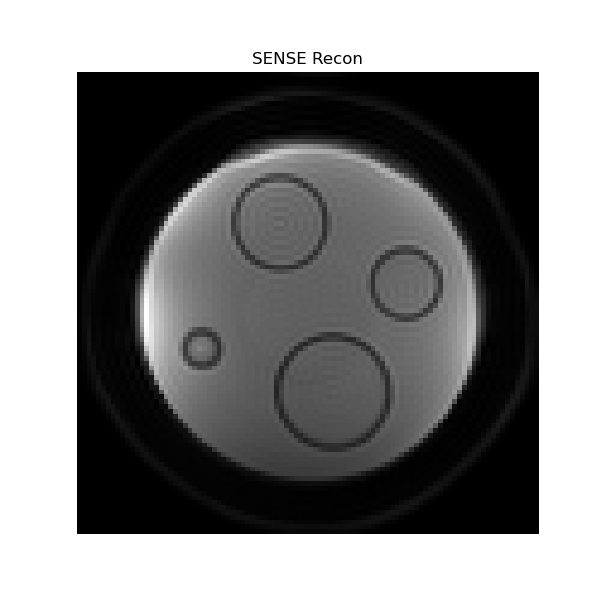

In [101]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("SENSE Recon")
ax.imshow(
    torch.abs(img[0, ..., 0]).T,
    cmap="gray",
    origin="lower",
)
ax.axis("off")